# 4. Modelling

In this notebook, we shall use the data collected and the newly engineed features to create a predictive model to predict rain. The notebook will take on the following flow.

1. Imports
2. Establish baseline
    - define as imports from EDA
3. Data Preprocessing
    - Standard Scaler
    - Train-test Split

4. Data Modelling and obtaining predictions
5. Interpreting Results
    - Define Scoring metric
    - Analyzing missed predictions
    
* https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4
* https://stackoverflow.com/questions/62210221/walk-forward-with-validation-window-for-time-series-data-cross-validation

##### Time Series Cross Validation
* https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8
* https://goldinlocks.github.io/Time-Series-Cross-Validation/

##### TimeSeriesSplit
* https://www.kaggle.com/code/tomwarrens/timeseriessplit-how-to-use-it/notebook


##### Github proj references
* https://github.com/andretch/GA_project_4/blob/master/code/5.%20Modelling%2C%20Iteration%2C%20Limitations%2C%20CBA%2C%20Recommendations%20%26%20Conclusion.ipynb


##### Polynomial Features
* https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92

## 4.1 Imports

As usual, we shall import the usual libraries, along with the relevant libraries associated with modelling. 
Specifically, the logistic regression, and the random forest modules shall be imported. 
Also, the data set with the features shall also be imported.

In [56]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from ast import literal_eval as make_tuple

In [57]:
# Import preprocessing packages
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Import Modelling packages
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# from sklearn import metrics
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

## 4.1.1 Create new dataframe by location

Due to the large spatial-temporal system, the dataframe shall be split into 14 distinct stations for modelling.<br> A pipeline shall then be created to repeat the modelling process across all 14 stations.

In [58]:
station_ids = ['station_S100', 'station_S104', 'station_S106', 'station_S107',
               'station_S108', 'station_S109', 'station_S111', 'station_S115',
               'station_S116', 'station_S121', 'station_S24', 'station_S43',
               'station_S44', 'station_S50']

## 4.2 Baseline Model
To determine if modelling improved our baseline understanding of the system, we shall develop a fairly straightforward baseline model. <br>
The logic was derived primarily from the EDA conducted in previous notebooks.<br>
The pseudo code is as follows:<br>
- if month in [3,4] and hour in range(12,18) OR
-    month in [5] and hour in range(11,16) OR
-    month in [8] and hour in range(5,13) OR
-    month in [9] and hour in range(3,7) OR
-    month in [11] and hour in range(14,17) OR
-    month in [12] and hour in range(5,13)
    - df['rain'] = 1
    - else 0
    

#### 4.2.1 Create Custom Function to generate baseline prediction

In [59]:
def generate_baseline(df):
    
    #hard code rain table since 
    def rain_table(month,hour):
        if(
            (month in [3,4] and hour in range(12,18)) or
            (month in [5] and hour in range(11,16)) or
            (month in [8] and hour in range(5,12)) or
            (month in [9] and hour in range (3,7)) or
            (month in [11] and hour in range(14,17)) or
            (month in [12] and hour == 16)
          ):
            return 1
        else:
            return 0
            
    # isolate month, hour and rain results column
    df = df[['month','hour','rain_consec_20']]
    rain_consec_20_predict = []
    
    for row in range(df.shape[0]):
        month, hour = tuple(df.iloc[row, 0:2])
        rain_consec_20_predict.append(rain_table(month, hour))
        
#     df['baseline_pred'] = np.array(rain_consec_20_predict)
    df['baseline_pred'] = rain_consec_20_predict
    
    scores = {}
    scores['F1'] = f1_score(df['rain_consec_20'], rain_consec_20_predict)
    scores['Precision'] = precision_score(df['rain_consec_20'], rain_consec_20_predict)
    scores['Recall'] = recall_score(df['rain_consec_20'], rain_consec_20_predict)
    scores['balanced_scoring'] = 0.75 * scores['Recall'] + 0.25 * scores['Precision']
    scores['Accuracy'] = accuracy_score(df['rain_consec_20'], rain_consec_20_predict)
    scores['tn'], scores['fp'], scores['fn'], scores['tp'] = confusion_matrix(df['rain_consec_20'], rain_consec_20_predict).ravel()
        
    return df, scores

#### 4.2.2 Generate predictions for all station data, and obtain country-level baseline score.

In this section, we shall loop through all stations to generate the predictions, and obtain their respective scores.<br>
For country-level baseline score, we shall sum up all raw scores (ie True Negatives, True Positives, False Negatives, False Positives) and recalculate the scoring metrics accordingly.

In [62]:
def countrywide_baseline(station_list):
    
    tn, tp, fn, fp = (0,0,0,0)
    
    for station in station_list:
        filepath = '../data/03_weather_df_add_feat' + station + '.csv'
        df = pd.read_csv(filepath, parse_dates = ['timestamp'])
        _ , scores = generate_baseline(df)
        
        tn = tn + scores['tn']
        tp = tp + scores['tp']
        fn = fn + scores['fn']
        fp = fp + scores['fp']
        
    scores = {}
    scores['Accuracy'] = (tp + tn) / (tn + tp + fn + fp)
    scores['Recall'] = (tp) / (tp + fn)
    scores['Precision'] = (tp) / (tp + fp)
    scores['balanced_scoring'] = 0.75 * scores['Recall'] + 0.25 * scores['Precision']
    scores['tn'], scores['fp'], scores['fn'], scores['tp'] = (tn, fp, fn, tp)
    
    return scores

In [63]:
baseline = countrywide_baseline(station_ids)

C:\Users\zmlee\AppData\Local\Temp\ipykernel_7428\2531959586.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['baseline_pred'] = rain_consec_20_predict
C:\Users\zmlee\AppData\Local\Temp\ipykernel_7428\2531959586.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['baseline_pred'] = rain_consec_20_predict
C:\Users\zmlee\AppData\Local\Temp\ipykernel_7428\2531959586.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [68]:
baseline

{'Accuracy': 0.8752541281026952,
 'Recall': 0.2710319871100663,
 'Precision': 0.029397608310747704,
 'balanced_scoring': 0.21062339241023664,
 'tn': 2560363,
 'fp': 338781,
 'fn': 27598,
 'tp': 10261}

#### 4.2.3 General Observations on baseline model

Clearly, while the baseline model scores an 87.5% accuracy, this is unsurprising with the large class imbalance skewed towards the no-rain class.<br>
We also see other metrics such as <i>Recall</i> and <i>Precision</i> fare poorly, scoring a highest of 27% with the Recall score.
<br><br>
From the breakdown of the individual components, we can see that this is a fairly intuitive and conservative model, where a user assumes rain to be present given certain time of the day. <br>
However, we also see that this baseline model is also unable to accurately predict occurence of rain, where false negatives are unable to be captured well within the predictions.

## 4.3 Data Preprocessing
Now that we have the data split based on their individual station locations, we shall proceed with splitting the dataframe into train and test sets. <br>
Due to the temporal nature of the data, it is important to take note that setting up the usual train-test split have some slightly different nuances as compared to the usual approach. <br>
This will be covered in the sections below. 

#### 4.3.1 Train-Test Split

In this section, we shall define some simple custom functions to address the issues associated with time series modelling. <br>
In this case, we shall proceed with a Walk-Forward Train-Test split approach.<br>
We shall use a 90% chronological train-test split, which roughly translates to 
* 21 months of training data and
* 3 months of testing data
<br><br>

#### 4.3.2 Standard Scaler & Cross Validation
Given the wide range of values, units of measurements, and also scale of data, it would be important to ensure that the values are scaled accordingly to ensure that the model avoids placing overemphasis on any single variable.<br>
Also, similar to the train-test-split, cross validation shall follow a sliding window approach.<br>

#### 4.3.3 Class Imbalance & Oversampling
While Singapore remains to be a tropical country with high amounts of rainfall, it is not constantly raining across every hour.<br>
This results in a class imbalance where there is a minority target class (of rain) as compared to having a well-distributed, pattern across time. <br>
However, given the complexities of time-series resampling, this shall be ignored.


#### 4.3.4 Polynomial Features
Lastly, polynomial features up to degree 3 shall be considered to harness the potential predictive capacity of the interaction terms. 

In [ ]:
def PolynomialFeatures_labeled(input_df,power):
    '''Basically this is a cover for the sklearn preprocessing function. 
    The problem with that function is if you give it a labeled dataframe, it ouputs an unlabeled dataframe with potentially
    a whole bunch of unlabeled columns. 
    Inputs:
    input_df = Your labeled pandas dataframe (list of x's not raised to any power) 
    power = what order polynomial you want variables up to. (use the same power as you want entered into pp.PolynomialFeatures(power) directly)
    Ouput:
    Output: This function relies on the powers_ matrix which is one of the preprocessing function's outputs to create logical labels and 
    outputs a labeled pandas dataframe   
    '''
    poly = PolynomialFeatures(power, interaction_only=True)
    output_nparray = poly.fit_transform(input_df)
    powers_nparray = poly.powers_

    input_feature_names = list(input_df.columns)
    target_feature_names = ["Constant Term"]
    for feature_distillation in powers_nparray[1:]:
        intermediary_label = ""
        final_label = ""
        for i in range(len(input_feature_names)):
            if feature_distillation[i] == 0:
                continue
            else:
                variable = input_feature_names[i]
                power = feature_distillation[i]
                intermediary_label = "%s^%d" % (variable,power)
                if final_label == "":         #If the final label isn't yet specified
                    final_label = intermediary_label
                else:
                    final_label = final_label + " x " + intermediary_label
        target_feature_names.append(final_label)
    output_df = pd.DataFrame(output_nparray, columns = target_feature_names)
    return output_df

## 4.4 Grid Search for optimized Parameters
In this section, we define a custom function to determine the best parameters to maximize recall score. <br>
Two models will be developed, namely the 
* Logistic Regression, and
* Random Forest Classifier

These models were used due to their ease of training.

### 4.4.0 Define gridsearch function

In [35]:
def get_fit(X, y, clf, clf_params, station_name = None,
            train_size = 0.90,
            data_validity = 0.7,
            train_window_cv_months = 12,
            horizon_test_cv_months = 1
           ):
        
    '''
    return X_train, X_test, y_train, y_test
    '''

    
    # Train Test Split (Walk forward Implementation)
    train_rows = int(len(X) * train_size)
    X_train, X_test = X[0:train_rows], X[train_rows:len(X)]
    y_train, y_test = y[0:train_rows], y[train_rows:len(X)]
    
    # Set up Cross Validation variables
    cv_rows = int(len(X_train))
    max_train_size = int(round(data_validity*train_window_cv_months*30*24*60/5,0))
    test_size = int(round(data_validity*horizon_test_cv_months*30*24*60/5,0))
#     n_splits = int(round(0.9*(cv_rows - (max_train_size + test_size) + 1), 0))
    
    tscv = TimeSeriesSplit(n_splits = 8,
                           max_train_size = max_train_size,
                           test_size = test_size)
       
    pipe = Pipeline(steps = [('ss', StandardScaler()),
                             #('sm', SMOTE(random_state = 42)),
                             ('clf', clf)
                            ],
                   verbose = True
                   )

    # Gridsearch for best estimator
    grid = GridSearchCV(pipe,
                        param_grid = clf_params,
                        scoring='recall',
                        cv= tscv,
                        n_jobs=-1)
    
    # Fit model
    grid.fit(X_train,y_train)
    print(f'Classifier: {clf}')
    print('Best Parameters:', grid.best_params_)
    cv_score = grid.cv_results_['mean_test_score'][0]
    bp = grid.best_params_

    y_train_preds = grid.predict(X_train)
    y_test_preds = grid.predict(X_test)

    # Obtain Scores
    scores = {'Station': station_name, 'Classifier': {clf}}
    scores['F1'] = f1_score(y_test, y_test_preds)
    scores['Precision'] = precision_score(y_test, y_test_preds)
    scores['Recall'] = recall_score(y_test, y_test_preds)
    scores['balanced_scoring'] = 0.75 * scores['Recall'] + 0.25 * scores['Precision']
    scores['Accuracy'] = accuracy_score(y_test, y_test_preds)
    scores['cv_accuracy'] = cv_score
    scores['tn'], scores['fp'], scores['fn'], scores['tp'] = confusion_matrix(y_test, y_test_preds).ravel()
    scores['best_params'] = bp

        
#     pipe
    print('Predictions Complete!')
    return scores #,pipe

### 4.4.1 Define Gridsearch Parameters

In [31]:
# LogisticRegression
lr = LogisticRegression()
lr_params = {
    'clf__l1_ratio': [0, 0.25, 0.5],
    'clf__max_iter': [1000],
    'clf__penalty': ['l1', 'l2'],
    'clf__solver' : ['liblinear']
}

# Random Forest Classifier
rfc = RandomForestClassifier()
rfc_params = {
    'clf__n_jobs': [-1],
    'clf__n_estimators': [30,35,40,45],
    'clf__max_depth': [14,15,16,17]
}

# List of classifiers & params
classifiers = [
    (lr, lr_params),
    (rfc, rfc_params),
]

### 4.4.2 Conduct Gridsearch

In [4]:
df_station_S24 = pd.read_csv('../data/03_weather_df_add_featstation_S24.csv', parse_dates = ['timestamp'])
df_station_S24.drop(columns = ['index','timestamp'], inplace = True)

In [5]:
df_station_S24 = df_station_S24.dropna(axis = 0)
X = df_station_S24.drop(columns = ['rain_consec_20'])
y = df_station_S24['rain_consec_20']

In [32]:
clf_scores = []
for clf, clf_params in classifiers:
    score = get_fit(X,y,
                    clf = clf,
                    clf_params = clf_params
                   );
    clf_scores.append(score)

[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.3s


C:\Users\zmlee\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[Pipeline] ............... (step 2 of 2) Processing clf, total= 3.3min
Classifier: LogisticRegression()
Best Parameters: {'clf__l1_ratio': 0, 'clf__max_iter': 1000, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Predictions Complete!
[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.3s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   4.0s
Classifier: RandomForestClassifier()
Best Parameters: {'clf__max_depth': 16, 'clf__n_estimators': 40, 'clf__n_jobs': -1}
Predictions Complete!


In [37]:
pd.DataFrame(clf_scores)

,Classifier,Station,F1,Precision,Recall,balanced_scoring,Accuracy,cv_accuracy,tn,fp,fn,tp,best_params
0,{LogisticRegression()},None,0.508287,0.575000,0.455446,0.485334,0.991673,0.527890,21105,68,110,92,"{'clf__l1_ratio': 0, 'clf__max_iter': 1000, 'c..."
1,{RandomForestClassifier()},None,0.353791,0.653333,0.242574,0.345264,0.991626,0.293717,21147,26,153,49,"{'clf__max_depth': 16, 'clf__n_estimators': 40..."


#### Observations from sample training 
From the following table, we see that there are currently two main problems that can be identified when using these two models.

1. <u>High risk of over fitting</u>
    - As can be seen from the cross validated accuracy scores, we see that the model suffers from severe overfitting and is not generalizable across time.
2. <u>Trade-off between Precision and Recall is more pronounced</u>
    - Another issue arising from the choosing between the two models is that there is a clear trade-off between proportion of false-negatives, and false-positives. Given that we are not predicting the <u>amount of rain</u>, a conservative approach is to assume that all rain events are heavy rains, False negative predictions tend to result in heavier penalties to the business (for eg. loss of revenue).
    
#### Path Forward
As such, we shall focus using the <u>Logistic Regression Model</u> given that it is able to
1. Have a faster training speed
2. Have a better "balanced" score compared to the Random Forest Model.

### 4.4.3 Get model fit for all stations

In [39]:
clf_scores[0]['best_params']

{'clf__l1_ratio': 0,
 'clf__max_iter': 1000,
 'clf__penalty': 'l1',
 'clf__solver': 'liblinear'}

In [4]:
def get_fit_lr(X, y, station_name = None,
            train_size = 0.90,
            data_validity = 0.7,
            train_window_cv_months = 12,
            horizon_test_cv_months = 1
           ):
        
    '''
    return X_train, X_test, y_train, y_test
    '''

    
    # Train Test Split (Walk forward Implementation)
    train_rows = int(len(X) * train_size)
    X_train, X_test = X[0:train_rows], X[train_rows:len(X)]
    y_train, y_test = y[0:train_rows], y[train_rows:len(X)]
    
    # Set up pipeline       
    pipe = Pipeline(steps = [('ss', StandardScaler()),
                             #('sm', SMOTE(random_state = 42)),
                             ('lr', LogisticRegression(penalty = 'l1',
                                                       solver = 'liblinear',
                                                       max_iter = 1000
                                                      ))
                            ],
                   verbose = True
                   )

    # Fit model
    pipe.fit(X_train,y_train)
    y_train_preds = pipe.predict(X_train)
    y_test_preds = pipe.predict(X_test)

#     # Set up Cross Validation variables
#     cv_rows = int(len(X_train))
#     max_train_size = int(round(data_validity*train_window_cv_months*30*24*60/5,0))
#     test_size = int(round(data_validity*horizon_test_cv_months*30*24*60/5,0))
#     tscv = TimeSeriesSplit(n_splits = 8,
#                        max_train_size = max_train_size,
#                        test_size = test_size)
    
#     cv_score = cross_val_score(pipe, X_train, y_train, cv = tscv).mean()
    
    # Obtain Scores
    scores = {'Station': station_name, 'Classifier': LogisticRegression()}
    scores['F1'] = f1_score(y_test, y_test_preds)
    scores['Precision'] = precision_score(y_test, y_test_preds)
    scores['Recall'] = recall_score(y_test, y_test_preds)
    scores['balanced_scoring'] = 0.75 * scores['Recall'] + 0.25 * scores['Precision']
    scores['Accuracy'] = accuracy_score(y_test, y_test_preds)
    scores['tn'], scores['fp'], scores['fn'], scores['tp'] = confusion_matrix(y_test, y_test_preds).ravel()
#     scores['cv_score'] = cv_score

    print('Predictions Complete!')
    return scores, pipe #,pipe

In [7]:
scores, pipe = get_fit_lr(X,y)

[Pipeline] ................ (step 1 of 2) Processing ss, total=   0.3s
[Pipeline] ................ (step 2 of 2) Processing lr, total= 3.7min
Predictions Complete!


In [5]:
def get_predict_all():
    station_ids = ['station_S100', 'station_S104', 'station_S106', 'station_S107',
                   'station_S108', 'station_S109', 'station_S115','station_S116',
                   'station_S24', 'station_S43', 'station_S44', 'station_S50']

    scores_all_stations = []
    coef_all_stations = []
    coef_interpret_all_stations = []

    print('=============================== BEGIN LOOP ===============================')
    ################################################################################################################################
    for station in station_ids:
        # Filter from df
        print(f'    -------------------------- {station} --------------------------')
        filepath = '../data/03_weather_df_add_feat'+station+'.csv'    
        df = pd.read_csv(filepath, parse_dates = ['timestamp'])
        df.drop(columns = ['index','timestamp'], inplace = True)
        df = df.dropna(axis = 0)
        X = df.drop(columns = ['rain_consec_20'])
        y = df['rain_consec_20']

        #get prediction
        scores, pipe = get_fit_lr(X,y, station_name = station)

        # append to scores list
        scores_all_stations.append(scores)
        
        # create dictionary of coefs
        coef_dict = {col: pipe[1].coef_[0][i] for i,col in enumerate(X.columns)}
        coef_all_stations.append(coef_dict)

        
        # create column for coeff interpretation
        array_mean = pipe[0].mean_
        array_vars = pipe[0].var_
        array_coef = pipe[1].coef_[0]
        coef_interpret_dict = {col: (round(array_mean[i],4), round(array_vars[i],4), round(array_coef[i],4)) for i,col in enumerate(X.columns)}
        coef_interpret_all_stations.append(coef_interpret_dict)
        
    ################################################################################################################################
        
    #Create dataframes for merge    
    df_scores_all_station = pd.DataFrame(scores_all_stations)
    
    df_coeff_all_station = pd.DataFrame(coef_all_stations)
    df_coeff_all_station = df_coeff_all_station.add_suffix('_coef') 
    
    df_coeff_intepret_all_stations = pd.DataFrame(coef_interpret_all_stations)
    df_coeff_intepret_all_stations = df_coeff_intepret_all_stations.add_suffix('_coef_interpret') 

    df_final = df_scores_all_station.join([df_coeff_all_station,df_coeff_intepret_all_stations])

    

    print('================================= END LOOP ===============================')    
    return df_final

In [4]:
%%time
# df_final_predict = get_predict_all()
# df_final_predict.to_csv('../data/04_df_final_predict.csv', index = False)
df_final_predict = pd.read_csv('../data/04_df_final_predict.csv'    )
df_final_predict.head(15)

CPU times: total: 15.6 ms
Wall time: 22.1 ms


,Station,Classifier,F1,Precision,Recall,balanced_scoring,Accuracy,tn,fp,fn,...,S115_rain_coef_interpret,S116_rain_coef_interpret,S117_rain_coef_interpret,S121_rain_coef_interpret,S122_rain_coef_interpret,S24_rain_coef_interpret,S43_rain_coef_interpret,S44_rain_coef_interpret,S50_rain_coef_interpret,S60_rain_coef_interpret
0,station_S100,LogisticRegression(),0.560209,0.587912,0.535000,0.548228,0.992038,20825,75,93,...,"(0.0287, 0.0279, 0.0258)","(0.0292, 0.0283, 0.0242)","(0.0129, 0.0128, -0.0099)","(0.0309, 0.03, 0.137)","(0.0131, 0.013, 0.0407)","(0.0287, 0.0278, 0.0054)","(0.0308, 0.0299, 0.0021)","(0.0326, 0.0315, 0.0753)","(0.0314, 0.0304, 0.0864)","(0.0118, 0.0117, -0.0044)"
1,station_S104,LogisticRegression(),0.506494,0.650000,0.414894,0.473670,0.988430,19361,63,165,...,"(0.029, 0.0282, 0.0089)","(0.03, 0.0291, 0.0166)","(0.0138, 0.0136, -0.024)","(0.0316, 0.0306, 0.1069)","(0.0142, 0.014, 0.0488)","(0.0293, 0.0284, 0.0224)","(0.0315, 0.0305, 0.0304)","(0.0329, 0.0318, 0.0252)","(0.0313, 0.0303, 0.0147)","(0.0126, 0.0125, 0.0104)"
2,station_S106,LogisticRegression(),0.145455,0.333333,0.093023,0.153101,0.990488,19561,32,156,...,"(0.0294, 0.0285, 0.0363)","(0.0293, 0.0284, 0.0051)","(0.0125, 0.0123, -0.0136)","(0.031, 0.0301, 0.0011)","(0.0135, 0.0133, -0.01)","(0.0285, 0.0277, 0.2087)","(0.0311, 0.0302, 0.0533)","(0.0332, 0.0321, 0.0243)","(0.0316, 0.0306, 0.0318)","(0.0114, 0.0113, 0.0017)"
3,station_S107,LogisticRegression(),0.407080,0.610619,0.305310,0.381637,0.990254,20353,44,157,...,"(0.0286, 0.0278, 0.0033)","(0.0286, 0.0278, -0.0003)","(0.0127, 0.0125, -0.0088)","(0.0302, 0.0293, 0.0361)","(0.0142, 0.014, -0.0271)","(0.0277, 0.0269, 0.1549)","(0.0296, 0.0287, 0.0325)","(0.032, 0.031, 0.0547)","(0.0299, 0.029, 0.0004)","(0.0121, 0.012, 0.0262)"
4,station_S108,LogisticRegression(),0.431373,0.666667,0.318841,0.405797,0.989079,15692,33,141,...,"(0.016, 0.0157, 0.0228)","(0.0126, 0.0125, 0.0493)","(0.0047, 0.0047, 0.0288)","(0.017, 0.0167, 0.0341)","(0.0053, 0.0052, -0.0628)","(0.012, 0.0119, 0.0392)","(0.0129, 0.0127, 0.0991)","(0.0181, 0.0178, 0.0118)","(0.0146, 0.0144, 0.0451)","(0.0038, 0.0037, 0.1138)"
5,station_S109,LogisticRegression(),0.568000,0.666667,0.494774,0.537747,0.988984,19249,71,145,...,"(0.0287, 0.0279, 0.0223)","(0.0291, 0.0283, 0.0244)","(0.0115, 0.0114, -0.0119)","(0.0308, 0.0299, 0.0027)","(0.0126, 0.0125, 0.025)","(0.0278, 0.0271, 0.0985)","(0.0301, 0.0292, 0.1322)","(0.032, 0.031, 0.025)","(0.0305, 0.0295, 0.0706)","(0.0118, 0.0116, -0.0029)"
6,station_S115,LogisticRegression(),0.395683,0.350318,0.454545,0.428489,0.991940,20620,102,66,...,"(0.0297, 0.0288, 0.3474)","(0.03, 0.0291, 0.1061)","(0.0129, 0.0127, 0.0556)","(0.0315, 0.0305, 0.0737)","(0.0137, 0.0135, 0.0419)","(0.029, 0.0281, 0.0263)","(0.0311, 0.0302, -0.0006)","(0.0333, 0.0322, 0.145)","(0.0318, 0.0308, 0.0097)","(0.0116, 0.0115, 0.0161)"
7,station_S116,LogisticRegression(),0.454277,0.596899,0.366667,0.424225,0.990619,19459,52,133,...,"(0.0164, 0.0162, 0.0398)","(0.0125, 0.0124, 0.2387)","(0.0063, 0.0063, 0.0421)","(0.0173, 0.017, 0.0037)","(0.0079, 0.0078, -0.012)","(0.0174, 0.0171, 0.0108)","(0.018, 0.0176, -0.011)","(0.0175, 0.0172, 0.0302)","(0.0158, 0.0156, 0.1039)","(0.0069, 0.0068, 0.0514)"
8,station_S24,LogisticRegression(),0.508287,0.575000,0.455446,0.485334,0.991673,21105,68,110,...,"(0.0287, 0.0279, -0.0025)","(0.0293, 0.0284, 0.0279)","(0.0127, 0.0125, 0.0136)","(0.031, 0.03, 0.0023)","(0.0136, 0.0135, -0.0057)","(0.0287, 0.0279, 0.271)","(0.0308, 0.0299, 0.0491)","(0.0326, 0.0316, 0.0465)","(0.031, 0.03, 0.014)","(0.0116, 0.0115, -0.0233)"
9,station_S43,LogisticRegression(),0.504310,0.700599,0.393939,0.470604,0.988516,19681,50,180,...,"(0.0223, 0.0218, 0.013)","(0.0215, 0.0211, 0.0454)","(0.0096, 0.0095, 0.0016)","(0.0228, 0.0223, -0.0109)","(0.0098, 0.0097, 0.0045)","(0.0195, 0.0191, 0.091)","(0.0203, 0.0199, 0.2387)","(0.0248, 0.0242, -0.0036)","(0.022, 0.0216, 0.0354)","(0.0084, 0.0083, 0.0173)"


### 4.4.4 Analysis on Prediction Results

Now that we have the model outputs, we shall take a look at the results.

In [8]:
df_scores = df_final_predict.loc[:, ['Station','tn','tp','fn','fp','balanced_scoring']]

In [9]:
df_scores.sort_values(by = 'balanced_scoring', ascending = False)

,Station,tn,tp,fn,fp,balanced_scoring
0,station_S100,20825,107,93,75,0.548228
5,station_S109,19249,142,145,71,0.537747
10,station_S44,21069,106,131,53,0.502110
8,station_S24,21105,92,110,68,0.485334
1,station_S104,19361,117,165,63,0.473670
9,station_S43,19681,117,180,50,0.470604
11,station_S50,16337,77,117,54,0.444627
6,station_S115,20620,55,66,102,0.428489
7,station_S116,19459,77,133,52,0.424225
4,station_S108,15692,66,141,33,0.405797


In [5]:
stations_df = pd.read_csv('../data/00_stationdata.csv')
stations_df['Station'] = ['station_'+station_id for station_id in list(stations_df['id'])]
stations_df = stations_df.loc[:, ['Station','name']]
stations_df.head()

,Station,name
0,station_S77,Alexandra Road
1,station_S109,Ang Mo Kio Avenue 5
2,station_S90,Bukit Timah Road
3,station_S114,Choa Chu Kang Avenue 4
4,station_S50,Clementi Road


In [12]:
df_w_location = df_scores.merge(right = stations_df,how = 'inner', on = 'Station')
df_w_location = df_w_location.sort_values(by = 'balanced_scoring', ascending = False)
df_w_location

,Station,tn,tp,fn,fp,balanced_scoring,name
0,station_S100,20825,107,93,75,0.548228,Woodlands Road
5,station_S109,19249,142,145,71,0.537747,Ang Mo Kio Avenue 5
10,station_S44,21069,106,131,53,0.502110,Nanyang Avenue
8,station_S24,21105,92,110,68,0.485334,Upper Changi Road North
1,station_S104,19361,117,165,63,0.473670,Woodlands Avenue 9
9,station_S43,19681,117,180,50,0.470604,Kim Chuan Road
11,station_S50,16337,77,117,54,0.444627,Clementi Road
6,station_S115,20620,55,66,102,0.428489,Tuas South Avenue 3
7,station_S116,19459,77,133,52,0.424225,West Coast Highway
4,station_S108,15692,66,141,33,0.405797,Marina Gardens Drive


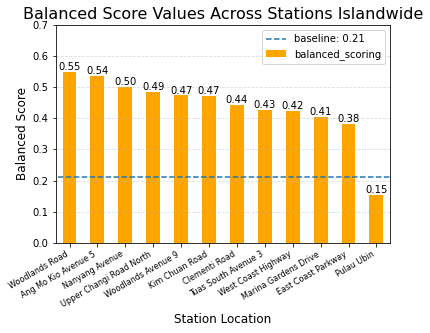

In [13]:
chart = df_w_location.plot.bar(x = 'name', y = 'balanced_scoring', color = 'orange');
chart.grid(axis = 'y', linestyle = '--', alpha = 0.45)
chart.set_xticklabels(chart.get_xticklabels(),
                     rotation = 30,
                     horizontalalignment = 'right',
                     fontsize = 8);
chart.hlines(y = 0.21062339241023664, xmin =-1, xmax = 15, linestyles = 'dashed', label = 'baseline: 0.21')
chart.bar_label(chart.containers[0], fmt = '%.2f');
chart.set_xlabel('Station Location', fontsize = 12);
chart.set_ylabel('Balanced Score', fontsize = 12);
chart.axis(ymin = 0, ymax = .70);
chart.set_title('Balanced Score Values Across Stations Islandwide', fontsize = 16);
chart.legend(loc = 'upper right');

With the exception of the <i>Pulau Ubin</i> station, it is clear that the predicted scores exist within a relatively tight range.<br>

While this is certainly concerning from a modelling perspective, it is less than relavant to the problem at hand, and can be easily disregarded given that business opportunities on the island are significantly lower, and are more subject to weather conditions to the nearby Malaysian areas - none of which we actively have data on. <br>

### 4.4.5 Country-level Balanced Scoring

Now that we have identified outliers, we shall remove them, and compute the relevant scores for the country-level predictions.

In [44]:
#save as new df
df_scores_country = df_scores.loc[:,['tp','tn','fp','fn']]
dict_scores_country = df_scores_country.sum().to_dict()

# unpack to obtain raw scores
(tp,tn,fp,fn) = dict_scores_country.values()
dict_scores_country['Station'] = 'Country-Average'

# calc individual scores
dict_scores_country['Recall'] = (tp) / (tp + fn)
dict_scores_country['Precision'] = (tp) / (tp + fp)
dict_scores_country['balanced_scoring'] = 0.75 * dict_scores_country['Recall'] + 0.25 * dict_scores_country['Precision']

# Remove irrelevant keys
dict_scores_country.pop('Recall')
dict_scores_country.pop('Precision')

dict_scores_country['name'] = 'Country Average'
dict_scores_country

{'tp': 1041,
 'tn': 233312,
 'fp': 697,
 'fn': 1594,
 'Station': 'Country-Average',
 'balanced_scoring': 0.44604089194978636,
 'name': 'Country Average'}

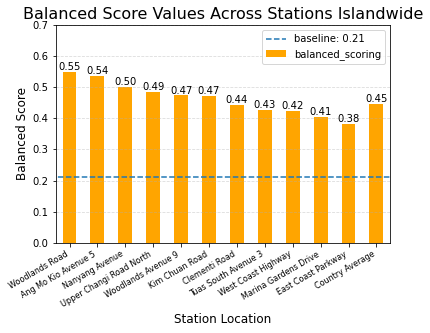

In [73]:
df_w_location_w_avg = df_w_location.append(dict_scores_country, ignore_index = True)
df_w_location_w_avg.drop(index = 11, inplace = True)


chart = df_w_location_w_avg.plot.bar(x = 'name', y = 'balanced_scoring', color = 'orange');
chart.grid(axis = 'y', linestyle = '--', alpha = 0.45)
chart.set_xticklabels(chart.get_xticklabels(),
                     rotation = 30,
                     horizontalalignment = 'right',
                     fontsize = 8);
chart.hlines(y = 0.21062339241023664, xmin =-1, xmax = 15, linestyles = 'dashed', label = 'baseline: 0.21')
chart.bar_label(chart.containers[0], fmt = '%.2f');
chart.set_xlabel('Station Location', fontsize = 12);
chart.set_ylabel('Balanced Score', fontsize = 12);
chart.axis(ymin = 0, ymax = .70);
chart.set_title('Balanced Score Values Across Stations Islandwide', fontsize = 16);
chart.legend(loc = 'upper right');

### 4.4.6 Top Influential Factors

Now that we have the list of coefficients, we shall take a look at which are the top 10 influential factors that have a tendency to result in rain.

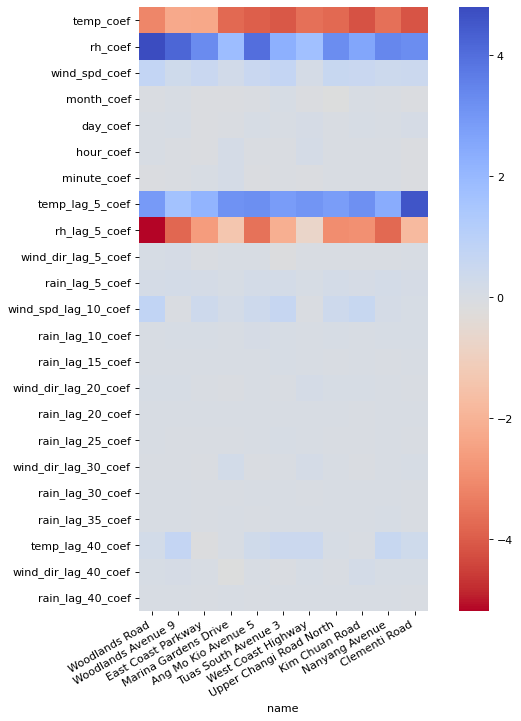

In [172]:
def get_influential_features(df, station_df):
    
    # Get coefficient matrix
    df = df.merge(station_df)
    df_coef = df.iloc[:,11:106].T
    df_coef.columns = df.loc[:,'name']

    #Split out relevant and irrelevant values
    df_coef_relevant = df_coef.loc[(df_coef!=0).all(axis=1)]
#     df_coef_relevant_location = df_coef_relevant.loc[df_coef_relevant.index.str.endswith('_rain_coef')]
    df_coef_relevant_feat = df_coef_relevant.loc[~df_coef_relevant.index.str.endswith('_rain_coef')]
    df_coef_relevant_feat = df_coef_relevant_feat.drop(columns = 'Pulau Ubin')
    
#     df_coef_irrelevant = df_coef.loc[(df_coef==0).all(axis=1)]
    fig = plt.figure(figsize = (10,10), dpi =80)
    fig = sns.heatmap(df_coef_relevant_feat, cmap = 'coolwarm_r', square = True)
    fig.set_xticklabels(fig.get_xticklabels(),
                         rotation = 30,
                         horizontalalignment = 'right',
                         fontsize = 10);

    
    return df_coef_relevant_feat

df_influence = get_influential_features(df_final_predict, stations_df);


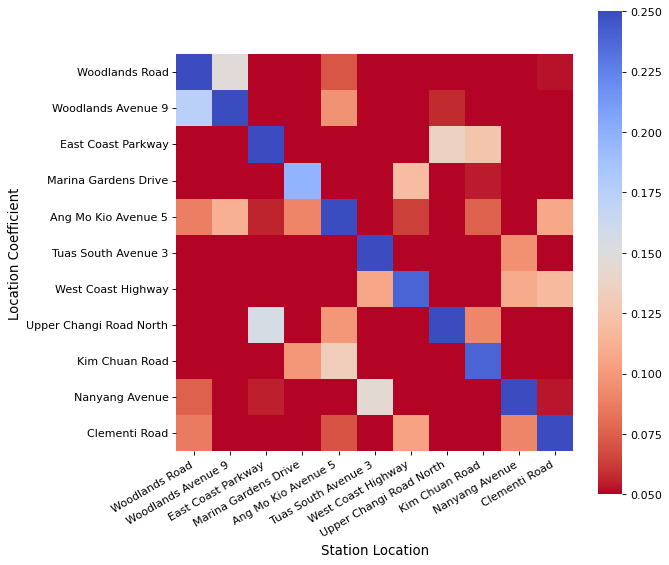

In [171]:
def get_influential_location(df, station_df):
    
    # Get coefficient matrix
    df = df.merge(station_df)
    df_coef = df.iloc[:,11:106].T
    df_coef.columns = df.loc[:,'name']

    #Split out relevant and irrelevant values
    df_coef_relevant = df_coef.loc[(df_coef!=0).all(axis=1)]
    df_coef_relevant_location = df_coef_relevant.loc[df_coef_relevant.index.str.endswith('_rain_coef')]
    df_coef_relevant_location = df_coef_relevant_location.iloc[[0,1,2,3,4,5,7,8,12,13,14,15]]
    df_coef_relevant_location.index = df_coef_relevant_location.columns
    df_coef_relevant_location = df_coef_relevant_location.drop(index = 'Pulau Ubin')
    df_coef_relevant_location = df_coef_relevant_location.drop(columns = 'Pulau Ubin')
    
#     df_coef_relevant_feat = df_coef_relevant.loc[~df_coef_relevant.index.str.endswith('_rain_coef')]
#     df_coef_irrelevant = df_coef.loc[(df_coef==0).all(axis=1)]
    fig = plt.figure(figsize = (8,8), dpi =80)
    fig = sns.heatmap(df_coef_relevant_location, cmap = 'coolwarm_r', square = True, center = 0.15, fmt = '.2f', vmax = 0.25, vmin = 0.05)
    fig.set_xticklabels(fig.get_xticklabels(),
                         rotation = 30,
                         horizontalalignment = 'right',
                         fontsize = 10);
    fig.set_ylabel('Location Coefficient', fontsize = 12);
    fig.set_xlabel('Station Location', fontsize = 12);

    
    return df_coef_relevant_location

get_influential_location(df_final_predict, stations_df);

From the heatmaps, at a station level, we see that the biggest and most influential factor was indeed described by what was observed in our EDA section: 
* a reduction in air temperature, along with a sharp spike in the relative humidity is a strong indicator for rain over the next 20 minutes. 

At a geographical level, we see that there are some interesting relationships that may be useful in real-world applications
* Rain at <i>Ang Mo Kio</i> tends to be a relatively strong predictor of rain at 
    - Woodlands
    - Marina Gardens Drive (Marina Barrage)
    - Kim Chuan Road (Serangoon Area)
    - Clementi Road
<br>
* Rain at <i>West Coast Highway</i> tends to be a relatively strong predictor of rain at 
    - Tuas South Avenue 3
    - Nanyang Avenue
    - Clementi road
<br>
* Rain at <i>East Coast Parkway</i> tends to be a relatively strong predictor of rain at 
    - Upper Changi Road North (Changi Area)
    - Kim Chuan Road (Serangoon Area)

### 4.4.7 Coefficient Interpretation

Now that we have identified the top most influential factors, we shall take an attempt at interpreting the what this means in an actual scenario.

From the previous heatmap, we've identified 4 main predictors:
* Temperature
* Relative Humidity
* Temperature, 5 minutes ago
* Relative Humidity, 5 minutes ago

While we see that there is clear strength in using these four predictors, it is difficult to vizualise lag and the effects of predicting rain. 

In [30]:
coef_interpret = df_final_predict.merge(stations_df)
coef_interpret = coef_interpret.loc[:, ['Station','name','temp_coef_interpret','rh_coef_interpret']]
coef_interpret

,Station,name,temp_coef_interpret,rh_coef_interpret
0,station_S100,Woodlands Road,"(28.0063, 6.1391, -3.1387)","(78.4199, 154.0241, 4.7971)"
1,station_S104,Woodlands Avenue 9,"(27.6044, 5.0946, -2.2973)","(77.6331, 131.1602, 4.1986)"
2,station_S106,Pulau Ubin,"(27.2947, 5.911, -3.9441)","(86.2777, 149.0348, 2.1227)"
3,station_S107,East Coast Parkway,"(28.1139, 2.4001, -2.3206)","(80.8486, 59.1088, 3.3068)"
4,station_S108,Marina Gardens Drive,"(28.9044, 4.2299, -3.7506)","(79.7949, 161.9771, 1.8622)"
5,station_S109,Ang Mo Kio Avenue 5,"(27.9699, 5.291, -3.9699)","(76.4757, 134.2866, 4.0134)"
6,station_S115,Tuas South Avenue 3,"(28.0936, 3.4935, -4.0875)","(78.8653, 74.669, 2.2737)"
7,station_S116,West Coast Highway,"(28.1666, 2.7078, -3.606)","(86.0655, 75.324, 1.7173)"
8,station_S24,Upper Changi Road North,"(27.9289, 4.2627, -3.7587)","(78.9099, 99.6138, 3.2706)"
9,station_S43,Kim Chuan Road,"(28.4834, 3.8542, -4.2002)","(79.6486, 119.308, 2.6041)"


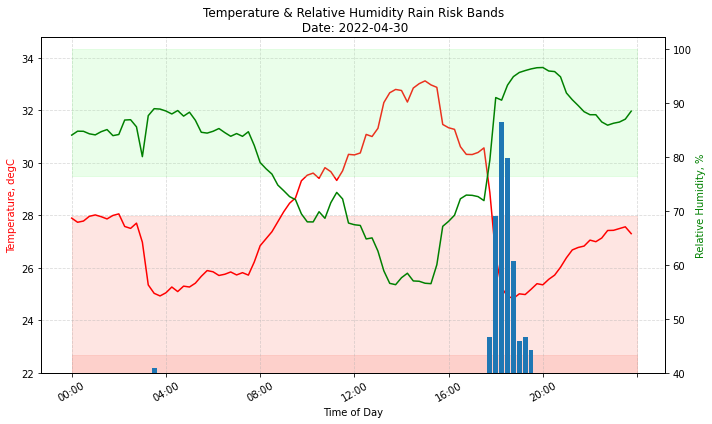

In [12]:
def viz_feat_impt(coef_interpret, station_id = 'station_S109'):
    coef_interpret = coef_interpret[coef_interpret['Station'] == station_id]
    temp_coef = make_tuple(coef_interpret[coef_interpret['Station'] == station_id].iloc[:,[2,3]]['temp_coef_interpret'].iloc[0])
    rh_coef = make_tuple(coef_interpret[coef_interpret['Station'] == station_id].iloc[:,[2,3]]['rh_coef_interpret'].iloc[0])
    temp_coef_mean, temp_coef_var, temp_coef_coef = temp_coef[0], temp_coef[1], temp_coef[2]
    rh_coef_mean, rh_coef_var, rh_coef_coef = rh_coef[0], rh_coef[1], rh_coef[2]
    
    station_id_num = station_id.split('_')[1]
    
    
    filepath = '../data/02_weather_daily.csv'
    weather_daily = pd.read_csv(filepath)
    weather_daily['timestamp'] = pd.to_datetime(weather_daily['timestamp'])
    weather_daily = weather_daily[weather_daily['year'] == 2022]
    weather_daily = weather_daily[weather_daily['month'] == 4]
    weather_daily = weather_daily[weather_daily['day'] == 30]
    weather_daily['time'] = pd.to_datetime(weather_daily['timestamp']).dt.strftime('%H:%M')
    
    weather_daily = weather_daily.loc[:,['station_id','name','timestamp','time','temp','rh','rain']]
    weather_daily = weather_daily[weather_daily['station_id'] == station_id_num]
    weather_daily = weather_daily.dropna()
    weather_daily = weather_daily.reset_index()
    weather_daily = weather_daily.drop(columns = ['index'])
    weather_daily = weather_daily.set_index('time')
    
    fig, ax1 = plt.subplots(figsize = (10,6))
    
    ax2 = ax1.twinx()
    ax3 = ax1.twinx()
#     ax4 = ax1.twinx()
    
    
    ax1.plot(weather_daily['temp'], label = 'Temperature, degC', c = 'Red')
    ax2.plot(weather_daily['rh'], label = 'Relative Humidity, %', c = 'Green')
    ax3.bar(x = weather_daily.index, height = weather_daily['rain'])

    ax1.fill_between(x = [0,96],
                    y1 = temp_coef_mean,
                    color = 'salmon',
                    alpha = 0.2)
    ax1.fill_between(x = [0,96],
                    y1 = temp_coef_mean - temp_coef_var,
                    color = 'salmon',
                    alpha = 0.2)
    
    ax2.fill_between(x = [0,96],
                    y1 = rh_coef_mean,
                    y2 = 100,
                    color = 'palegreen',
                    alpha = 0.2)
#     ax2.fill_between(x = [0,96],
#                     y1 = rh_coef_mean + rh_coef_var,
#                     y2 = 100,
#                     color = 'palegreen',
#                     alpha = 0.2)
    
    ax1.set_xlabel('Time of Day')
    ax1.xaxis.set_major_locator(plt.MultipleLocator(16))
    ax1.tick_params(axis='x', labelrotation = 30)
    ax1.set_ylabel('Temperature, degC', color='r')
    ax2.set_ylabel('Relative Humidity, %', color='g')
    ax3.get_yaxis().set_visible(False)
    ax1.axis(ymin = 22)
    ax2.axis(ymin = 40)
    ax3.axis(ymax = 15)
    ax1.grid(axis = 'y', linestyle = '--', alpha = 0.45)
    ax1.grid(axis = 'x', linestyle = '--', alpha = 0.45)
#     ax4.fill_between()
    
    
    
    plt.title('Temperature & Relative Humidity Rain Risk Bands\n Date: 2022-04-30')
    fig.tight_layout()
    plt.show()
    
    
    return weather_daily

temp_df = viz_feat_impt(coef_interpret)

In [55]:
def get_risk_range(coef_interpret):
    
    #initialize
    temp_mean, temp_vars, temp_coef = ([],[],[])
    rh_mean, rh_vars, rh_coef = ([],[],[])
    
    #run loop
    for i in coef_interpret.index:
        temp_tuple, rh_tuple = make_tuple(coef_interpret.iloc[i][2]), make_tuple(coef_interpret.iloc[i][3])
        
        # unpack tuple and append values to list
        temp_mean.append(temp_tuple[0])
        temp_vars.append(temp_tuple[1])
        temp_coef.append(temp_tuple[2])

        rh_mean.append(rh_tuple[0])
        rh_vars.append(rh_tuple[1])
        rh_coef.append(rh_tuple[2])
        
    #append column - temperature
    coef_interpret['temp_mean'] = temp_mean
    coef_interpret['temp_vars'] = temp_vars
    coef_interpret['temp_coef'] = temp_coef
    coef_interpret['temp_odds'] = np.exp(np.multiply(temp_coef, -1))

    #append column - rh
    coef_interpret['rh_mean'] = rh_mean
    coef_interpret['rh_vars'] = rh_vars
    coef_interpret['rh_coef'] = rh_coef
    coef_interpret['rh_odds'] = np.exp(rh_coef)
        
    coef_interpret = coef_interpret.drop(columns = ['temp_coef_interpret', 'rh_coef_interpret'])
    
    temp_avg_min, temp_avg_max = round(out['temp_mean'].min(),1), round(out['temp_mean'].max(),1)
    temp_var_min, temp_var_max = round(out['temp_vars'].min(),1), round(out['temp_vars'].max(),1)
    temp_odd_min, temp_odd_max = int(round(out['temp_odds'].min(),1)), int(round(out['temp_odds'].max(),1))

    rh_avg_min, rh_avg_max = round(out['rh_mean'].min(),1), round(out['rh_mean'].max(),1)
    rh_var_min, rh_var_max = round(out['rh_vars'].min(),1), round(out['rh_vars'].max(),1)
    rh_odd_min, rh_odd_max = int(round(out['rh_odds'].min(),1)), int(round(out['rh_odds'].max(),1))
    
    print("================== Report ==================")
    print("Temp Avg Range:          ", f"{temp_avg_min} - {temp_avg_max} degC")
    print("Temp Var Range:          ", f"{temp_var_min} - {temp_var_max} degC")
    print("Temp Odds Range:         ", f"{temp_odd_min} - {temp_odd_max} ")
    print("--------------------------------------------")
    print("RH Avg Range:             ", f"{rh_avg_min} - {rh_avg_max} %")
    print("RH Var Range:             ", f"{rh_var_min} - {rh_var_max} %")
    print("RH Odds Range:             ", f"{rh_odd_min} - {rh_odd_max}")
    print("================ End Report ================")
    
    return coef_interpret


out = get_risk_range(coef_interpret)

================== Report ==================
Temp Avg Range:           27.3 - 28.9 degC
Temp Var Range:           2.4 - 6.1 degC
Temp Odds Range:          9 - 66 
--------------------------------------------
RH Avg Range:              76.5 - 86.3 %
RH Var Range:              59.1 - 162.0 %
RH Odds Range:              5 - 121
================ End Report ================


In [65]:
out

,Station,name,temp_mean,temp_vars,temp_coef,temp_odds,rh_mean,rh_vars,rh_coef,rh_odds
0,station_S100,Woodlands Road,28.0063,6.1391,-3.1387,23.073851,78.4199,154.0241,4.7971,121.158548
1,station_S104,Woodlands Avenue 9,27.6044,5.0946,-2.2973,9.947288,77.6331,131.1602,4.1986,66.593035
2,station_S106,Pulau Ubin,27.2947,5.9110,-3.9441,51.629850,86.2777,149.0348,2.1227,8.353662
3,station_S107,East Coast Parkway,28.1139,2.4001,-2.3206,10.181782,80.8486,59.1088,3.3068,27.297633
4,station_S108,Marina Gardens Drive,28.9044,4.2299,-3.7506,42.546602,79.7949,161.9771,1.8622,6.437885
5,station_S109,Ang Mo Kio Avenue 5,27.9699,5.2910,-3.9699,52.979233,76.4757,134.2866,4.0134,55.334689
6,station_S115,Tuas South Avenue 3,28.0936,3.4935,-4.0875,59.590729,78.8653,74.6690,2.2737,9.715281
7,station_S116,West Coast Highway,28.1666,2.7078,-3.6060,36.818484,86.0655,75.3240,1.7173,5.569471
8,station_S24,Upper Changi Road North,27.9289,4.2627,-3.7587,42.892629,78.9099,99.6138,3.2706,26.327131
9,station_S43,Kim Chuan Road,28.4834,3.8542,-4.2002,66.699670,79.6486,119.3080,2.6041,13.519053


### 4.5 Conclusion